In [3]:
import pandas as pd
import numpy as np
import math
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

from statsmodels.tsa.stattools import adfuller
import itertools
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('train.csv')

## Dataset cleanup for Prophet

### 1. Train model with **Monthly** data

In [5]:
df_ts = df[['Order Date', 'Sales']]
df_ts['Order Date'] = pd.to_datetime(df_ts['Order Date'], format = "%d/%m/%Y")

In [6]:
sales_mon = df_ts.resample('M', on = 'Order Date').sum()
sales_mon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2015-01-31 to 2018-12-31
Freq: ME
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [7]:
sales_mon.reset_index(inplace = True)
sales_mon = sales_mon.rename(columns = {'Order Date': 'ds', 'Sales': 'y'})
sales_mon.head()

,ds,y
0,2015-01-31,14205.707
1,2015-02-28,4519.892
2,2015-03-31,55205.797
3,2015-04-30,27906.855
4,2015-05-31,23644.303


In [8]:
train_data = sales_mon[sales_mon['ds'] < "2018-01-01"]
test_data = sales_mon[sales_mon['ds'] >= "2018-01-01"]

- Modeling

In [9]:
model = Prophet()
model.fit(train_data)

13:36:39 - cmdstanpy - INFO - Chain [1] start processing
13:36:40 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future = model.make_future_dataframe(periods = 365, freq = 'M')
forecast = model.predict(future)

* Visualize the forecast data

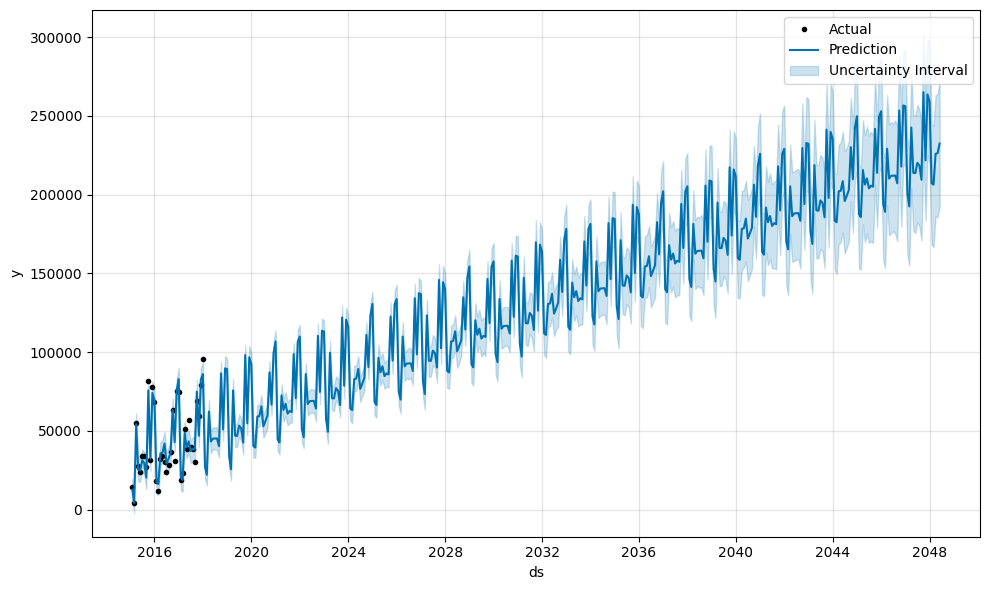

In [11]:
fig = model.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty Interval'])
plt.show()

* Compare the prediction and test data

<Axes: xlabel='ds'>

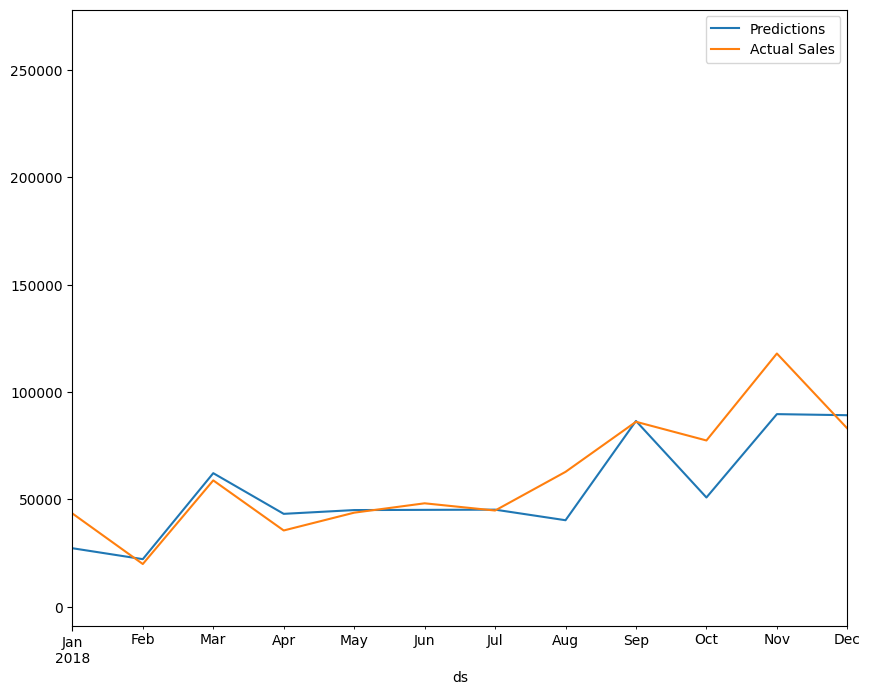

In [12]:
ax = forecast.plot(x = 'ds', y = 'yhat', legend = True, label = 'Predictions', figsize = (10, 8))
test_data.plot(x = 'ds', y = 'y', legend = True, label = 'Actual Sales', ax = ax, xlim = ('2018-01-31', '2018-12-31'))

* Let's see how the yearly and monthly pattern of the time series contribute to the overall forecasted values

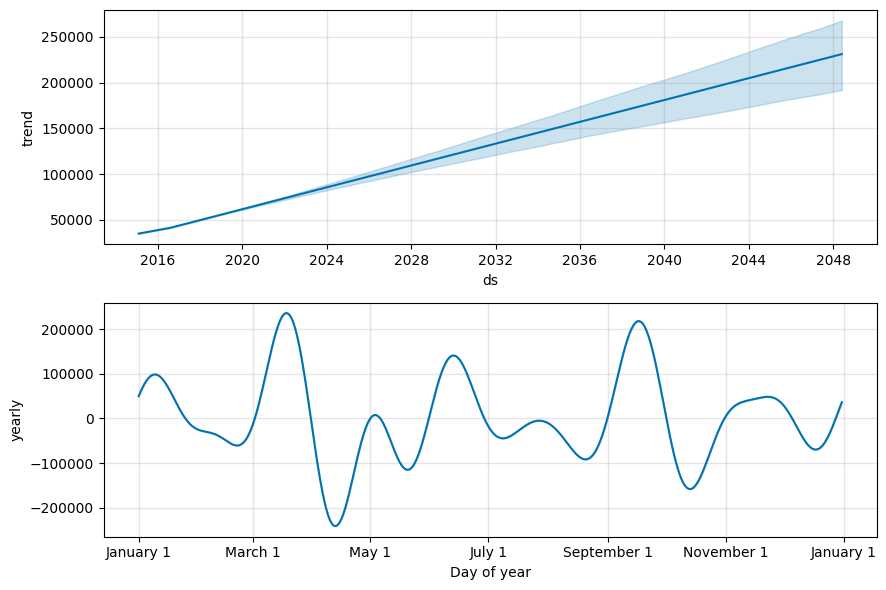

In [13]:
fig = model.plot_components(forecast)

In [ ]:
plot_plotly(model, forecast, changepoints = True)

- Evaluation

In [15]:
predictions = forecast.iloc[-len(test_data):]['yhat']
actuals = test_data['y']
print(f"RMSE: {round(rmse(predictions, actuals))}")

RMSE: 173564


#### Cross-validation

Time series cross-validation has to follow the time range, we'll use the cross-validation method built in Prophet.
| Parameters |
- Horizon: test period of each fold
- Initial: the size of the initial training period
- Period: time gap between cut-off dates

In [16]:
horizon = '180 days'

df_cv = cross_validation(model, horizon = horizon, parallel = 'processes')

13:36:52 - cmdstanpy - INFO - Chain [1] start processing
13:36:52 - cmdstanpy - INFO - Chain [1] start processing
13:36:52 - cmdstanpy - INFO - Chain [1] start processing
13:36:52 - cmdstanpy - INFO - Chain [1] start processing
13:36:53 - cmdstanpy - INFO - Chain [1] done processing
13:36:53 - cmdstanpy - INFO - Chain [1] done processing
13:36:59 - cmdstanpy - INFO - Chain [1] done processing
13:37:00 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
df_cv.head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-10-31,25448.495602,25380.977914,25505.276439,31011.7375,2016-10-07
1,2016-11-30,62414.743014,62206.866579,62600.562956,75249.3995,2016-10-07
2,2016-12-31,93545.232567,93153.541483,93907.706136,74543.6012,2016-10-07
3,2017-01-31,-6433.324804,-7057.192892,-5868.472291,18542.4910,2016-10-07
4,2017-02-28,1951.524320,1098.987441,2709.744822,22978.8150,2016-10-07
5,2017-03-31,32306.021874,31211.137770,33339.741392,51165.0590,2016-10-07
6,2017-01-31,3468.746571,3316.672606,3625.398821,18542.4910,2017-01-05
7,2017-02-28,4103.240641,3624.021023,4596.136185,22978.8150,2017-01-05
8,2017-03-31,33619.867058,32630.461584,34642.791276,51165.0590,2017-01-05
9,2017-04-30,25814.404269,24262.586590,27367.568796,38679.7670,2017-01-05


In [39]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mdape,smape,coverage
0,18 days,1.860486e+06,1363.996415,949.512121,0.888443,1.114368,0.966667
1,19 days,1.855471e+06,1362.156823,949.673170,0.853939,1.087159,0.966667
2,20 days,1.806855e+06,1344.192884,928.439943,0.888443,1.081132,0.966667
3,21 days,1.725280e+06,1313.499032,901.906786,0.927774,1.095364,0.966667
4,22 days,1.857827e+06,1363.021404,960.619557,1.447770,1.164210,0.966667
...,...,...,...,...,...,...,...
158,176 days,5.033073e+06,2243.451211,1671.001959,0.805071,0.988757,0.766667
159,177 days,4.762453e+06,2182.304624,1610.115922,0.831220,0.996258,0.788889
160,178 days,4.566440e+06,2136.922990,1535.870351,0.805071,0.950226,0.800000
161,179 days,4.550857e+06,2133.273811,1523.944431,0.831220,0.947399,0.800000


### 2. Train model with **Daily** data

In [22]:
df_ts = df[['Order Date', 'Sales']]
df_ts['Order Date'] = pd.to_datetime(df_ts['Order Date'], format = "%d/%m/%Y")

In [23]:
# sales_mon = df_ts.resample('M', on = 'Order Date').sum()
sales_daily = df_ts.resample('D', on = 'Order Date').sum()
sales_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1458 entries, 2015-01-03 to 2018-12-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   1458 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


In [24]:
sales_daily.reset_index(inplace = True)
sales_daily = sales_daily.rename(columns = {'Order Date': 'ds', 'Sales': 'y'})
sales_daily.head()

,ds,y
0,2015-01-03,16.448
1,2015-01-04,288.060
2,2015-01-05,19.536
3,2015-01-06,4407.100
4,2015-01-07,87.158


- Split train-test set

In [27]:
train_data = sales_daily[sales_daily['ds'] < "2018-01-01"]
test_data = sales_daily[sales_daily['ds'] >= "2018-01-01"]

- Modeling

In [28]:
model = Prophet()
model.fit(train_data)

13:37:50 - cmdstanpy - INFO - Chain [1] start processing
13:37:50 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
future = model.make_future_dataframe(periods = 365, freq = 'D')
forecast = model.predict(future)

* Visualize the forecast data

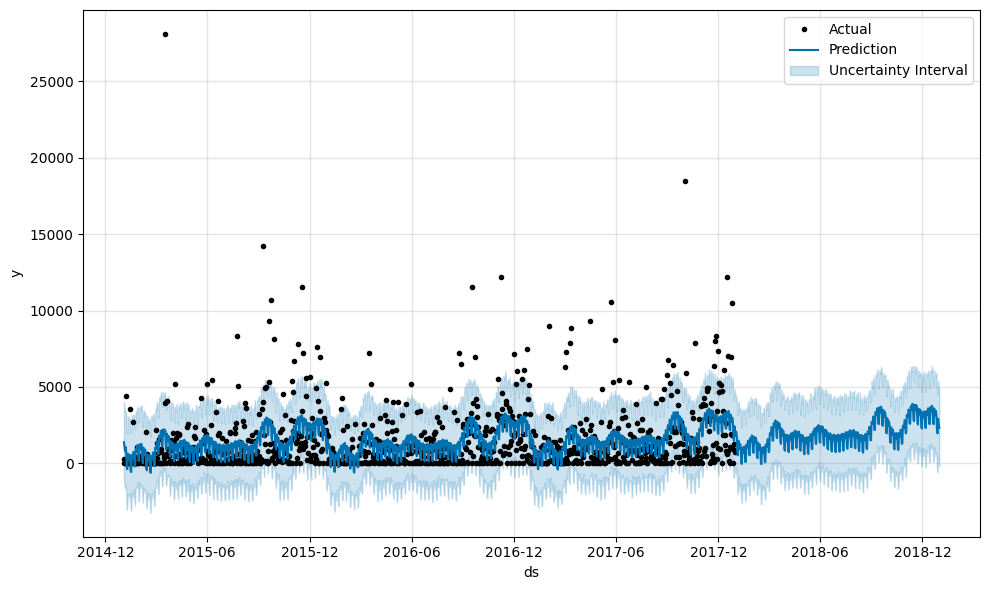

In [30]:
fig = model.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty Interval'])
plt.show()

* Compare the prediction and test data

<Axes: xlabel='ds'>

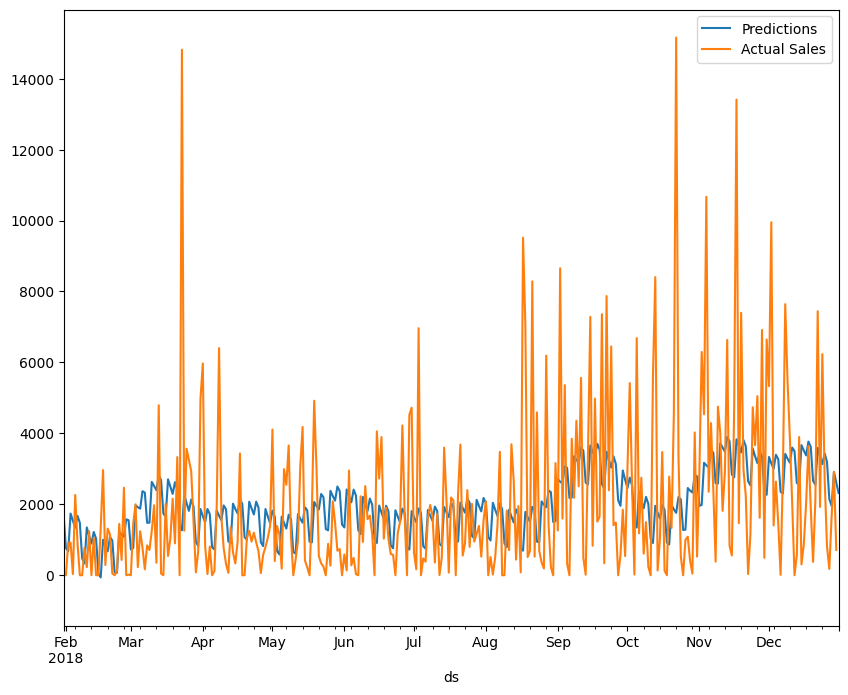

In [31]:
ax = forecast.plot(x = 'ds', y = 'yhat', legend = True, label = 'Predictions', figsize = (10, 8))
test_data.plot(x = 'ds', y = 'y', legend = True, label = 'Actual Sales', ax = ax, xlim = ('2018-01-31', '2018-12-31'))

* Let's see how the yearly, monthly, and weekly pattern of the time series contribute to the overall forecasted values

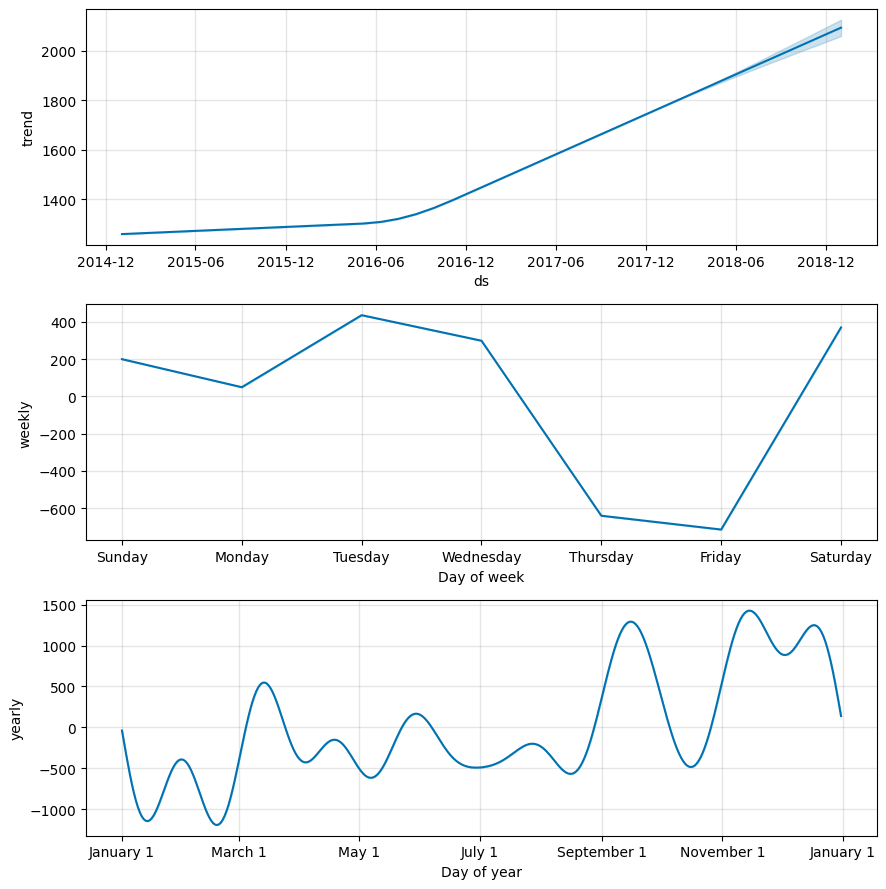

In [32]:
fig = model.plot_components(forecast)

In [ ]:
plot_plotly(model, forecast, changepoints = True)

- Evaluation

In [34]:
predictions = forecast.iloc[-len(test_data):]['yhat']
actuals = test_data['y']
print(f"RMSE: {round(rmse(predictions, actuals))}")

RMSE: 2151


#### Cross-validation

Time series cross-validation has to follow the time range, we'll use the cross-validation method built in Prophet.
| Parameters |
- Horizon: test period of each fold
- Initial: the size of the initial training period
- Period: time gap between cut-off dates

In [35]:
horizon = '180 days'
df_cv = cross_validation(model, horizon = horizon, parallel = 'processes')

13:38:06 - cmdstanpy - INFO - Chain [1] start processing
13:38:06 - cmdstanpy - INFO - Chain [1] done processing
13:38:06 - cmdstanpy - INFO - Chain [1] start processing
13:38:06 - cmdstanpy - INFO - Chain [1] done processing
13:38:06 - cmdstanpy - INFO - Chain [1] start processing
13:38:06 - cmdstanpy - INFO - Chain [1] start processing
13:38:06 - cmdstanpy - INFO - Chain [1] start processing
13:38:06 - cmdstanpy - INFO - Chain [1] done processing
13:38:06 - cmdstanpy - INFO - Chain [1] done processing
13:38:06 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
df_cv.head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-07-10,784.914084,-1453.306274,3139.723729,43.286,2016-07-09
1,2016-07-11,543.642810,-1970.563253,2790.167045,1941.952,2016-07-09
2,2016-07-12,1261.185786,-1027.913124,3667.762548,2052.567,2016-07-09
3,2016-07-13,1492.635855,-793.450378,3715.254877,2033.256,2016-07-09
4,2016-07-14,582.603357,-1775.763994,3046.049882,860.916,2016-07-09
5,2016-07-15,-90.294275,-2418.928928,2202.036520,0.000,2016-07-09
6,2016-07-16,1407.194591,-969.948379,3692.879172,3029.386,2016-07-09
7,2016-07-17,1215.348112,-1182.344941,3624.648664,448.082,2016-07-09
8,2016-07-18,1007.988674,-1195.931746,3384.530128,525.720,2016-07-09
9,2016-07-19,1752.872996,-692.752209,4196.221657,2.025,2016-07-09


In [38]:
performance_metrics(df_cv).head(10)

,horizon,mse,rmse,mae,mdape,smape,coverage
0,18 days,1.860486e+06,1363.996415,949.512121,0.888443,1.114368,0.966667
1,19 days,1.855471e+06,1362.156823,949.673170,0.853939,1.087159,0.966667
2,20 days,1.806855e+06,1344.192884,928.439943,0.888443,1.081132,0.966667
3,21 days,1.725280e+06,1313.499032,901.906786,0.927774,1.095364,0.966667
4,22 days,1.857827e+06,1363.021404,960.619557,1.447770,1.164210,0.966667
5,23 days,1.856432e+06,1362.509576,957.220767,1.525268,1.183555,0.966667
6,24 days,1.899528e+06,1378.233779,987.794601,1.322233,1.166770,0.966667
7,25 days,1.998900e+06,1413.824628,1026.632272,1.322233,1.159878,0.955556
8,26 days,1.970267e+06,1403.662012,1006.885823,0.927242,1.112447,0.955556
9,27 days,1.963603e+06,1401.286235,1009.863661,0.922781,1.102399,0.955556
